# NLP Project (Toxic comments classification)

23th May 2022

Students:
- Karam Shbeb
- Kamil Sabbagh

In this notebook, we will be solving the problem of toxic comments classification.

We will start by preprocssing of the data, preprocssing include:


*   Transforming the the data to pandas Data Frames
*   Checking for missing values in the labeling of the training and testing data
*   Checking for missing values in the comments of the training and testing data
*   Cleaning the commentes



We will be following the pipline sugested by the course materials:


*   Toknizing the data
*   Tagging
*   parsing


Finally we will be buidling a linear regression model to classify the commenets




# Preprocessing The Data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from statistics import mean
from sklearn.metrics import f1_score, recall_score, hamming_loss
from sklearn.linear_model import LogisticRegression
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import accuracy_score
from nltk.tokenize import TweetTokenizer 
from matplotlib import pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns
import pandas as pd
import nltk
import re
from matplotlib.pyplot import figure
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE

In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/karam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/karam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Load training and test data

In [4]:
# train_df = pd.read_csv("/content/drive/MyDrive/NLP toxic comments DS/train.csv")
# test_df = pd.read_csv("/content/drive/MyDrive/NLP toxic comments DS/test.csv")
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

## Examine the data 

In [5]:
train_df.head(5)  

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

In the training data, the comments are labelled as one or more of the six categories; toxic, severe toxic, obscene, threat, insult and identity hate. This is essentially a multi-label classification problem.

In [6]:
labels = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

We will next check if there are empty labels in the training and testing datasets

First training

In [7]:
for label in labels: 
  empty = len(train_df[train_df[label] == '']) 
  print(f"Number of empty values in the column {label} is: {empty}")

Number of empty values in the column obscene is: 0
Number of empty values in the column insult is: 0
Number of empty values in the column toxic is: 0
Number of empty values in the column severe_toxic is: 0
Number of empty values in the column identity_hate is: 0
Number of empty values in the column threat is: 0


Then testing 

In [8]:
for label in labels: 
  empty = len(test_df[train_df[label] == '']) 
  print(f"Number of empty values in the column {label} is: {empty}")


Number of empty values in the column obscene is: 0
Number of empty values in the column insult is: 0
Number of empty values in the column toxic is: 0
Number of empty values in the column severe_toxic is: 0
Number of empty values in the column identity_hate is: 0
Number of empty values in the column threat is: 0


/tmp/ipykernel_38203/2589419405.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  empty = len(test_df[train_df[label] == ''])


From this result we can see that there are no missing numeric values.

Next we will find the percentage of the unlabeled data in the training set

In [9]:
unlabelled = 0

for i in range(len(train_df)):
  count = 0
  for label in labels:
    if train_df[label][i] == 0:
      count+=1
  if count == 6:
    unlabelled +=1

print(f"Percentage of unlabelled/clean comments is {unlabelled/len(train_df)*100}%")

Percentage of unlabelled/clean comments is 89.83211235124176%


Next we will find the percentage of empty comments in the train and test datasets

In [10]:
# check for any 'null' comment
no_comment = train_df[train_df['comment_text'].isnull()]
len(no_comment)

0

In [11]:
# check for any 'null' comment
no_comment = test_df[test_df['comment_text'].isnull()]
len(no_comment)

0

All rows in the training and test data contain comments, so there's no need to clean up null fields.

let's see the total rows in train, test data and the numbers for the various categories

/home/karam/Documents/workspace/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


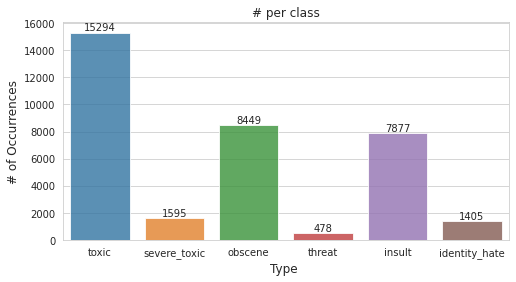

In [12]:
x=train_df.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
p_labels = x.values
for rect, label in zip(rects, p_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

The toxicity is not evenly spread out across classes. Hence we might face class imbalance problems
There are ~95k comments in the training dataset and there are ~21 k tags and ~86k clean comments!?
This is only possible when multiple tags are associated with each comment (eg) a comment can be classified as both toxic and obscene.

Let's look at the character length for the rows in the training data and record these, by looking at the histogram plot for text length

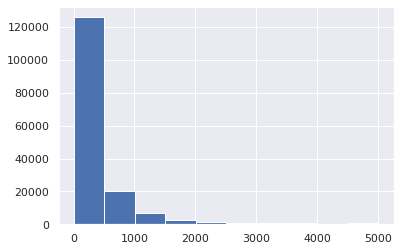

In [13]:
train_df['char_length'] = train_df['comment_text'].apply(lambda x: len(str(x)))
sns.set()
train_df['char_length'].hist()
plt.show()

Most of the text length are within 500 characters, with some up to 5,000 characters long.

In [14]:
train_df = train_df.drop('char_length',axis=1)

Next, let's examine the correlations among the target variables.

In [15]:
data = train_df[labels]

<AxesSubplot:>

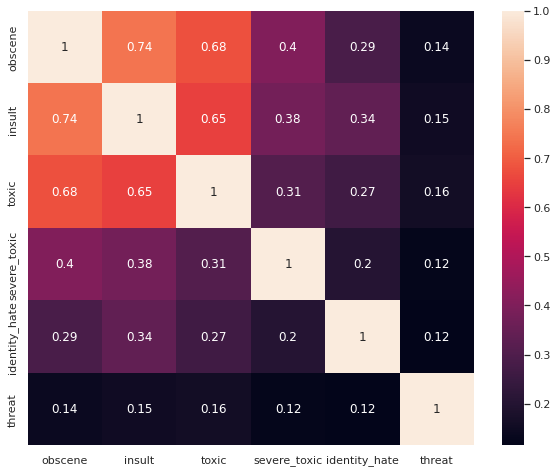

In [16]:
temp_df=data
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

Indeed, it looks like some of the labels are higher correlated, e.g. insult-obscene has the highest at 0.74, followed by toxic-obscene and toxic-insult.

In [17]:
from wordcloud import WordCloud

In [18]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_context = train_df[train_df[token] == 1]
    threat_text = threat_context.comment_text
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common words associated with {token} comment", size=20)
    plt.show()

In [19]:
labels = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

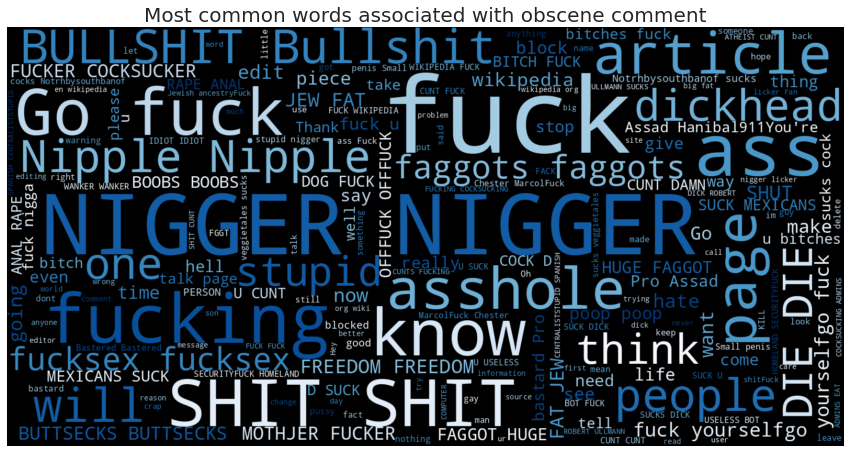

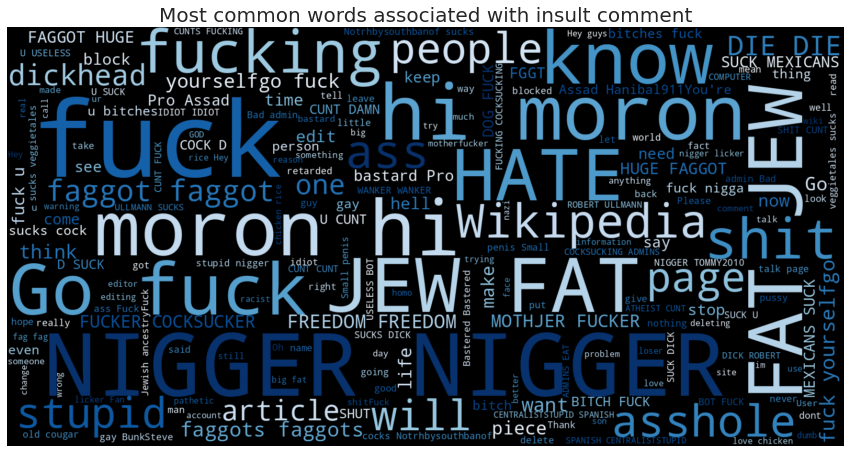

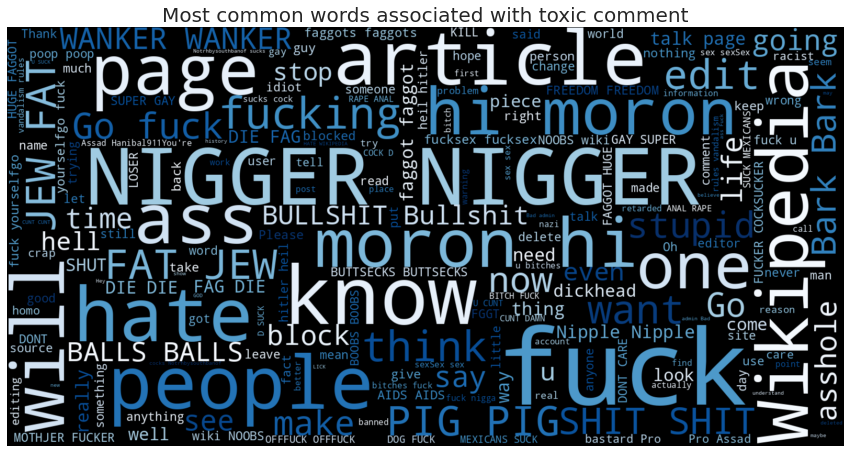

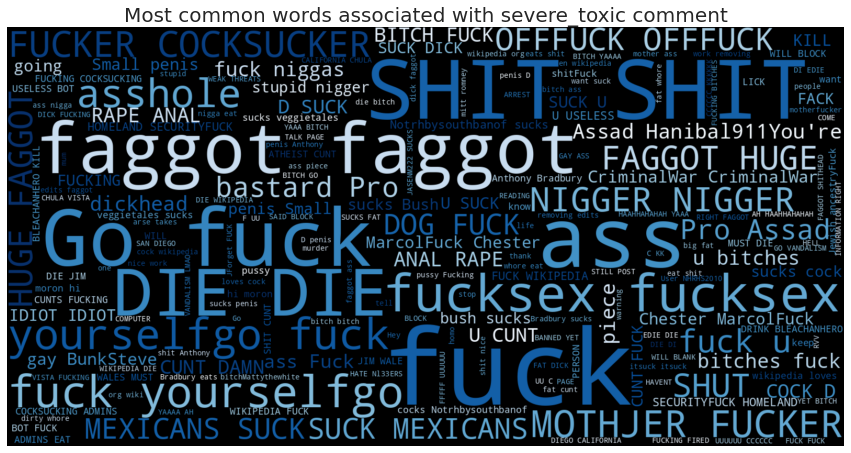

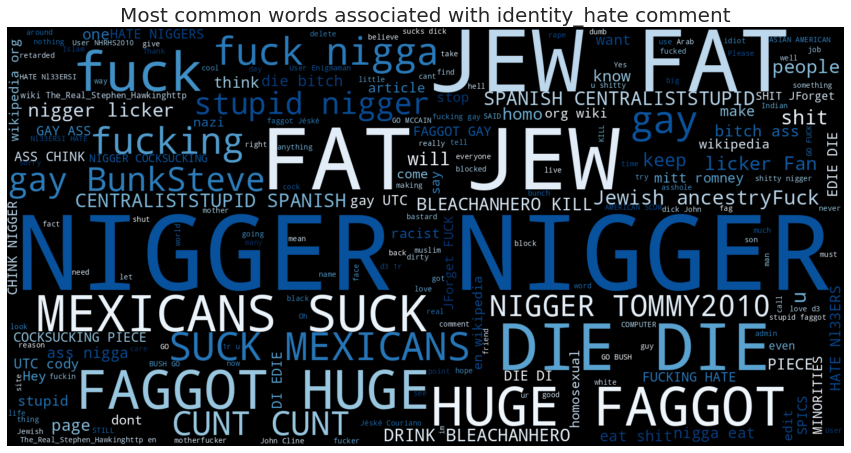

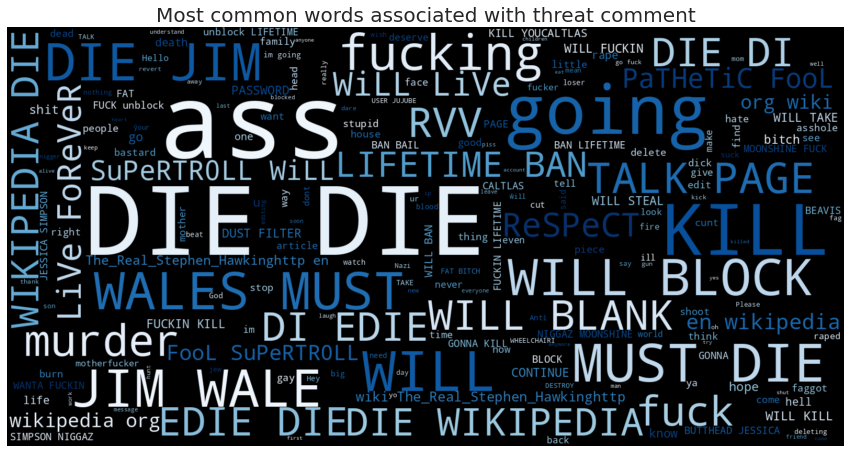

In [20]:
for label in labels:
  W_Cloud(label)

Multi-tagging:
Let's check how many comments have multiple tags.

/home/karam/Documents/workspace/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


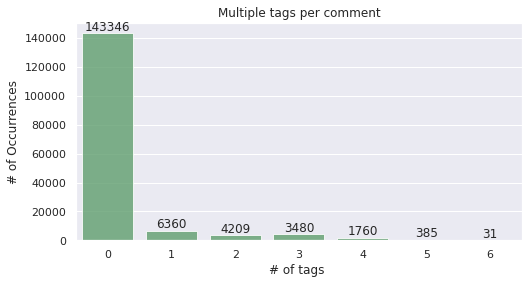

In [21]:
rowsums=train_df.iloc[:,2:].sum(axis=1)
color = sns.color_palette()
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,4))
ax = sns.barplot(x.index, x.values, alpha=0.8,color=color[2])
plt.title("Multiple tags per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of tags ', fontsize=12)

#adding the text labels
rects = ax.patches
p_labels = x.values
for rect, label in zip(rects, p_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

We can see that 89% of data is clean data and has not been labeled with any toxic behaviour. Furthermore, there are 31 commenets which has been labeled by all the toxic labels.

## Clean up the comment text

In [22]:
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [23]:
eng_stopwords = set(stopwords.words("english"))
lem = nltk.WordNetLemmatizer()
tokenizer=TweetTokenizer()

In [24]:
def clean_text(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words= tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    return(clean_sent)

In [25]:
# clean the comment_text in train_df [Thanks to Pulkit Jha for the useful pointer.]
train_df['comment_text'] = train_df['comment_text'].map(lambda com : clean_text(com))

In [26]:
# clean the comment_text in test_df [Thanks, Pulkit Jha.]
test_df['comment_text'] = test_df['comment_text'].map(lambda com : clean_text(com))


## Define X from entire train & test data for use in tokenization by Vectorizer

In [27]:
X = train_df.comment_text
test_X = test_df.comment_text

In [28]:
print(X.shape, test_X.shape)

(159571,) (153164,)


# NLP Pipeline

## Vectorize the data

In [29]:
# import and instantiate TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')

In [30]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
train_trans_X = vect.fit_transform(X)
test_trans_X = vect.transform(test_X)

## Solving a multi-label classification problem
One way to approach a multi-label classification problem is to transform the problem into separate single-class classifier problems. This is known as 'problem transformation'. There are three methods:
* _**Binary Relevance.**_ This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.
* _**Classifier Chains.**_ In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.
* _**Label Powerset.**_ This method transforms the problem into a multi-class problem  where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^6 or 64-class problem. {Thanks Joshua for pointing out.}

## Linear SVC classifier

In [31]:
svc = LinearSVC(C=12)
predicted_svc = pd.read_csv('data/sample_submission.csv')

for label in labels:
    y = train_df[label]
    # train the model
    svc.fit(train_trans_X,y)
    # compute the training accuracy
    y_pred_train = svc.predict(train_trans_X)
    acc = accuracy_score(y, y_pred_train)
    print(f'Training accuracy for label {label} is {acc}')
    # make predictions from test data
    test_y = svc.predict(test_trans_X)
    predicted_svc[label] = test_y

Training accuracy for label obscene is 0.9844959297115391
Training accuracy for label insult is 0.9767376277644434
Training accuracy for label toxic is 0.964962305180766
Training accuracy for label severe_toxic is 0.993332121751446
Training accuracy for label identity_hate is 0.9953750994854955
Training accuracy for label threat is 0.9991539816132003


In [32]:
predicted_svc

id  toxic  severe_toxic  obscene  threat  insult  \
0       00001cee341fdb12      1             0        1       0       1   
1       0000247867823ef7      0             0        0       0       0   
2       00013b17ad220c46      0             0        0       0       0   
3       00017563c3f7919a      0             0        0       0       0   
4       00017695ad8997eb      0             0        0       0       0   
...                  ...    ...           ...      ...     ...     ...   
153159  fffcd0960ee309b5      1             0        0       0       0   
153160  fffd7a9a6eb32c16      0             0        0       0       0   
153161  fffda9e8d6fafa9e      0             0        0       0       0   
153162  fffe8f1340a79fc2      0             0        0       0       0   
153163  ffffce3fb183ee80      1             0        1       0       0   

        identity_hate  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
153159              0  
153160              0  
153161              0  
153162              0  
153163              0  

[153164 rows x 7 columns]

## Binary Relevance - build a multi-label classifier using Logistic Regression

In [33]:
lr = LogisticRegression(C=12.0, max_iter=500)

# write predicted label for each item in test set
predicted_binary = pd.read_csv('data/sample_submission.csv')

for label in labels:
    y = train_df[label]
    # train the model
    lr.fit(train_trans_X, y)
    # compute the training accuracy
    y_pred_train = lr.predict(train_trans_X)
    acc = accuracy_score(y, y_pred_train)
    print(f'Training accuracy for label {label} is {acc}')
    # compute the predicted labels for test data
    y_pred = lr.predict(test_trans_X)
    predicted_binary[label] = y_pred

Training accuracy for label obscene is 0.9833491047872107
Training accuracy for label insult is 0.9758978761805089
Training accuracy for label toxic is 0.9647492338833498
Training accuracy for label severe_toxic is 0.9919220911067801
Training accuracy for label identity_hate is 0.9936642623033007
Training accuracy for label threat is 0.9979632890688158


In [34]:
predicted_binary

id  toxic  severe_toxic  obscene  threat  insult  \
0       00001cee341fdb12      1             0        1       0       1   
1       0000247867823ef7      0             0        0       0       0   
2       00013b17ad220c46      0             0        0       0       0   
3       00017563c3f7919a      0             0        0       0       0   
4       00017695ad8997eb      0             0        0       0       0   
...                  ...    ...           ...      ...     ...     ...   
153159  fffcd0960ee309b5      1             0        0       0       0   
153160  fffd7a9a6eb32c16      0             0        0       0       0   
153161  fffda9e8d6fafa9e      0             0        0       0       0   
153162  fffe8f1340a79fc2      0             0        0       0       0   
153163  ffffce3fb183ee80      1             0        1       0       1   

        identity_hate  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
153159              0  
153160              0  
153161              0  
153162              0  
153163              0  

[153164 rows x 7 columns]

## Classifier Chains - build a multi-label classifier using Logistic Regression

In [35]:
# create a function to add features
def add_feature(X, feature_to_add):
    '''
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    '''
    from scipy.sparse import csr_matrix, hstack
    return hstack([X, csr_matrix(feature_to_add).T], 'csr')

In [36]:
predicted_chains = pd.read_csv('data/sample_submission.csv')

for label in labels:
    y = train_df[label]
    # train the model
    lr.fit(train_trans_X,y)
    # compute the training accuracy
    y_pred_train = lr.predict(train_trans_X)
    acc = accuracy_score(y, y_pred_train)
    print(f'Training accuracy for label {label} is {acc}')
    # make predictions from test data
    test_y = lr.predict(test_trans_X)
    predicted_chains[label] = test_y
    # chain current label to train_trans_X
    train_trans_X = add_feature(train_trans_X, y)
    # chain current label predictions to test_trans_X
    test_trans_X = add_feature(test_trans_X, test_y)

Training accuracy for label obscene is 0.9833491047872107
Training accuracy for label insult is 0.9817886708737803
Training accuracy for label toxic is 0.9680706394018963
Training accuracy for label severe_toxic is 0.9928182439165011
Training accuracy for label identity_hate is 0.9951118937651579
Training accuracy for label threat is 0.9983518308464571


In [37]:
predicted_chains

id  toxic  severe_toxic  obscene  threat  insult  \
0       00001cee341fdb12      1             0        1       0       1   
1       0000247867823ef7      0             0        0       0       0   
2       00013b17ad220c46      0             0        0       0       0   
3       00017563c3f7919a      0             0        0       0       0   
4       00017695ad8997eb      0             0        0       0       0   
...                  ...    ...           ...      ...     ...     ...   
153159  fffcd0960ee309b5      1             0        0       0       0   
153160  fffd7a9a6eb32c16      0             0        0       0       0   
153161  fffda9e8d6fafa9e      0             0        0       0       0   
153162  fffe8f1340a79fc2      0             0        0       0       0   
153163  ffffce3fb183ee80      1             0        1       0       1   

        identity_hate  
0                   1  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
153159              0  
153160              0  
153161              0  
153162              0  
153163              0  

[153164 rows x 7 columns]

### Evaluation

In [38]:
test_labels = pd.read_csv('data/test_labels.csv')

In [39]:
test_labels

id  toxic  severe_toxic  obscene  threat  insult  \
0       00001cee341fdb12     -1            -1       -1      -1      -1   
1       0000247867823ef7     -1            -1       -1      -1      -1   
2       00013b17ad220c46     -1            -1       -1      -1      -1   
3       00017563c3f7919a     -1            -1       -1      -1      -1   
4       00017695ad8997eb     -1            -1       -1      -1      -1   
...                  ...    ...           ...      ...     ...     ...   
153159  fffcd0960ee309b5     -1            -1       -1      -1      -1   
153160  fffd7a9a6eb32c16     -1            -1       -1      -1      -1   
153161  fffda9e8d6fafa9e     -1            -1       -1      -1      -1   
153162  fffe8f1340a79fc2     -1            -1       -1      -1      -1   
153163  ffffce3fb183ee80     -1            -1       -1      -1      -1   

        identity_hate  
0                  -1  
1                  -1  
2                  -1  
3                  -1  
4                  -1  
...               ...  
153159             -1  
153160             -1  
153161             -1  
153162             -1  
153163             -1  

[153164 rows x 7 columns]

In [40]:
unlabelled_in_all = test_labels[(test_labels['toxic']!=-1) & (test_labels['severe_toxic']!=-1) & (test_labels['obscene']!=-1) &
                                (test_labels['threat']!=-1) & (test_labels['insult']!=-1) & (test_labels['identity_hate']!=-1)]
print('Percentage of rows that have all values as -1 ', len(unlabelled_in_all)/len(test_labels)*100)

unlabelled_in_all = test_labels[(test_labels['toxic']!=-1) | (test_labels['severe_toxic']!=-1) | (test_labels['obscene']!=-1) |
                                (test_labels['threat']!=-1) | (test_labels['insult']!=-1) | (test_labels['identity_hate']!=-1)]
print('Percentage of rows that have one -1 at least ', len(unlabelled_in_all)/len(test_labels)*100)

Percentage of rows that have all values as -1  41.77091222480478
Percentage of rows that have one -1 at least  41.77091222480478


We can see that 41.77% of rows in test set has -1 in all rows, and it’s not possible to have -1 with 0 or 1 in the same row

In [41]:
def score(predicted):
    score_df = []
    f1_values = []
    recall_values = []
    for label in labels:
        f1_value = f1_score(
            test_labels[test_labels[label] != -1][label], predicted[test_labels[label] != -1][label], average="weighted"
        )
        recall_value = recall_score(
            test_labels[test_labels[label] != -1][label], predicted[test_labels[label] != -1][label], average="weighted"
        )
        f1_values.append(f1_value)
        recall_values.append(recall_value)
        val = [label, f1_value, recall_value]
        score_df.append(val)
    hamming_loss_score = hamming_loss(
        test_labels[test_labels['toxic'] != -1].iloc[:, 1:7], predicted[test_labels['toxic'] != -1].iloc[:, 1:7])
    val = ['mean', mean(f1_values), mean(recall_values)]
    score_df.append(val)
    print('hamming loss is ',hamming_loss_score)
    return score_df

In [42]:
score_df = score(predicted_binary)
scores_binary = pd.DataFrame(score_df)
scores_binary.columns = ['label', 'F1', 'Recall']
scores_binary

hamming loss is  0.028780726708139255


label        F1    Recall
0        obscene  0.963574  0.963534
1         insult  0.959765  0.961049
2          toxic  0.929283  0.924412
3   severe_toxic  0.992623  0.992372
4  identity_hate  0.988530  0.989825
5         threat  0.995876  0.996124
6           mean  0.971608  0.971219

In [43]:
score_df = score(predicted_chains)
scores_chains = pd.DataFrame(score_df)
scores_chains.columns = ['label', 'F1', 'Recall']
scores_chains

hamming loss is  0.028421228130503195


label        F1    Recall
0        obscene  0.963574  0.963534
1         insult  0.958019  0.958830
2          toxic  0.931658  0.929069
3   severe_toxic  0.992373  0.992029
4  identity_hate  0.988603  0.989950
5         threat  0.995748  0.996061
6           mean  0.971663  0.971579

In [44]:
score_df = score(predicted_svc)
scores_svc = pd.DataFrame(score_df)
scores_svc.columns = ['label', 'F1', 'Recall']
scores_svc

hamming loss is  0.02947367324184355


label        F1    Recall
0        obscene  0.963105  0.963081
1         insult  0.959617  0.960658
2          toxic  0.928964  0.923958
3   severe_toxic  0.992422  0.992169
4  identity_hate  0.987433  0.988183
5         threat  0.995294  0.995108
6           mean  0.971139  0.970526

Let's compare the performance of the three models according to the Recall score

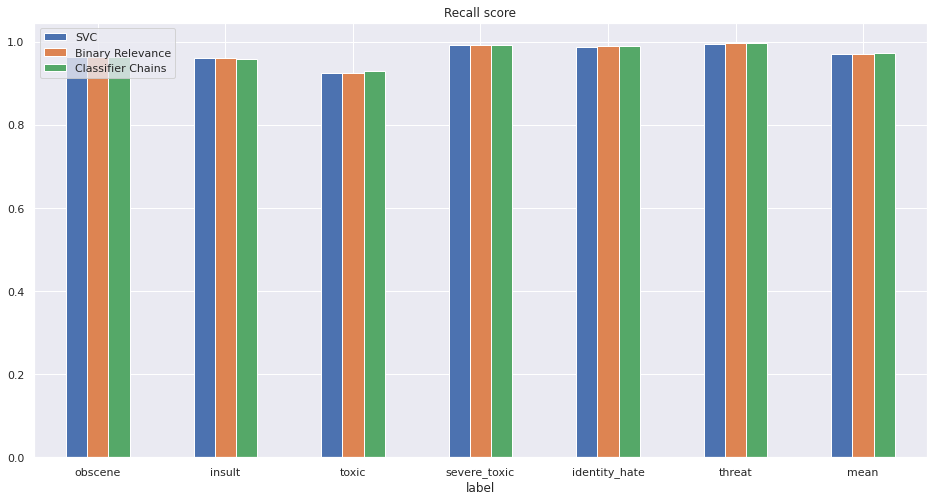

In [45]:
df = pd.DataFrame({'SVC': scores_svc['Recall'].to_list(),
                   'Binary Relevance': scores_binary['Recall'].to_list(),
                   'Classifier Chains': scores_chains['Recall'].to_list()}, index=scores_svc['label'])
ax = df.plot(figsize=(16, 8), kind='bar', title='Recall score', rot=0)
ax.legend(loc=2)

Since the Chains classifier was the best one let's pick the comments this model failed to classify them as toxic comments

In [46]:
misclassified_comments = {}
for label in labels:
    misclassified = predicted_chains[(predicted_chains[label] != 1) & (test_labels[label] == 1)]
    misclassified_text = pd.merge(misclassified, test_df, on='id')['comment_text']
    misclassified_comments[label] = misclassified_text

mis_comments = pd.DataFrame(misclassified_comments)
mis_comments.columns = labels
mis_comments

obscene  \
0     :: : well , suck university nicknameless . it ...   
1     = = argh = = random idiot delete whole japan a...   
2     ( hate america go bomb shit cities , queza ; r...   
3                                     simple : stupid !   
4      give blowjobs hot women alderley edge , cheshire   
...                                                 ...   
1716                                                NaN   
1717                                                NaN   
1718                                                NaN   
1719                                                NaN   
1720                                                NaN   

                                                 insult  \
0     = = argh = = random idiot delete whole japan a...   
1     :: : moi ? ego ? mortify could say thing - poo...   
2     " , tenth anniversary 9/11 , " " new york time...   
3     " random deletion = = delete " " xanax bar fuc...   
4     " : maybe one days . cool random quote , way ,...   
...                                                 ...   
1716                                                NaN   
1717                                                NaN   
1718                                                NaN   
1719                                                NaN   
1720                                                NaN   

                                                  toxic  \
0     = = arabs commit genocide iraq , protest europ...   
1     dare vandalize page hms beagle ! do not vandal...   
2     : eek , shes cute earthy kind way . cant sing ...   
3     :: : moi ? ego ? mortify could say thing - poo...   
4      give blowjobs hot women alderley edge , cheshire   
...                                                 ...   
1716  guess say months back idiot get toss gettting ...   
1717                          shut learn sign comment .   
1718  " : " " might mention fault resolution amicabl...   
1719  = = fourth baldrick possibly cleverer make = =...   
1720  " = = iran = = ’ right , iran . drone . spread...   

                                           severe_toxic  \
0                         casualt fuck mum like ! ! ies   
1     go court ? shit , cause judge look like mother...   
2                                        eat dick fag .   
3     stupid niggers like antandrus like shitonly st...   
4                        = = fuck cu block , faggot = =   
...                                                 ...   
1716                                                NaN   
1717                                                NaN   
1718                                                NaN   
1719                                                NaN   
1720                                                NaN   

                                          identity_hate  \
0                               ghay ass fucker @ @ ! !   
1     " random deletion = = delete " " xanax bar fuc...   
2     = = warn = = first warn , stop gay , rap ass i...   
3        = = willeys = = u male willey u likley gay lol   
4     go court ? shit , cause judge look like mother...   
...                                                 ...   
1716                                                NaN   
1717                                                NaN   
1718                                                NaN   
1719                                                NaN   
1720                                                NaN   

                                                 threat  
0     ( hate america go bomb shit cities , queza ; r...  
1     users like make wikipedia shithole . you are f...  
2     azerbaijanis proud ramil safarov opportunity c...  
3     I will kill piss mouth anyone support soviet s...  
4     oh , also take 1000 % responsibility . worthle...  
...                                                 ...  
1716                                                NaN  
1717                                   

Let's check the most common misclassified words

In [47]:
def W_Cloud(token):
    """
    Visualize the most common words contributing to the token.
    """
    threat_text = mis_comments[token]
    neg_text = pd.Series(threat_text).str.cat(sep=' ')
    wordcloud = WordCloud(width=1600, height=800,
                          max_font_size=200).generate(neg_text)

    plt.figure(figsize=(15, 10))
    plt.imshow(wordcloud.recolor(colormap="Blues"), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Most common misclassified words associated with {token} comment", size=20)
    plt.show()

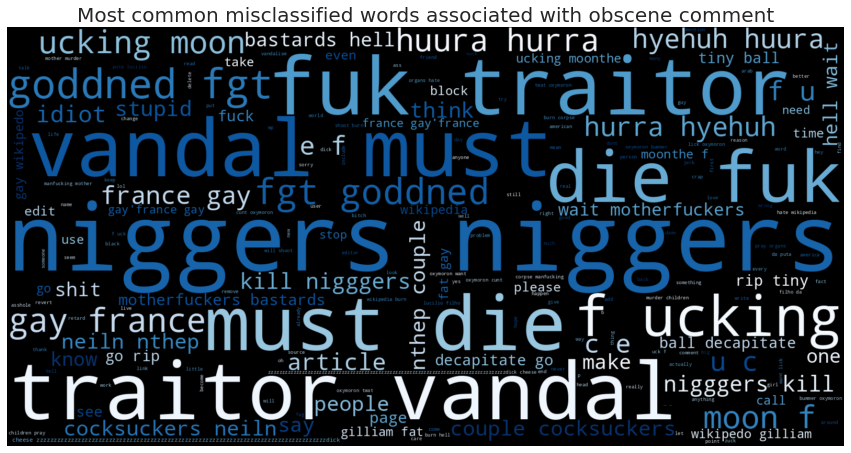

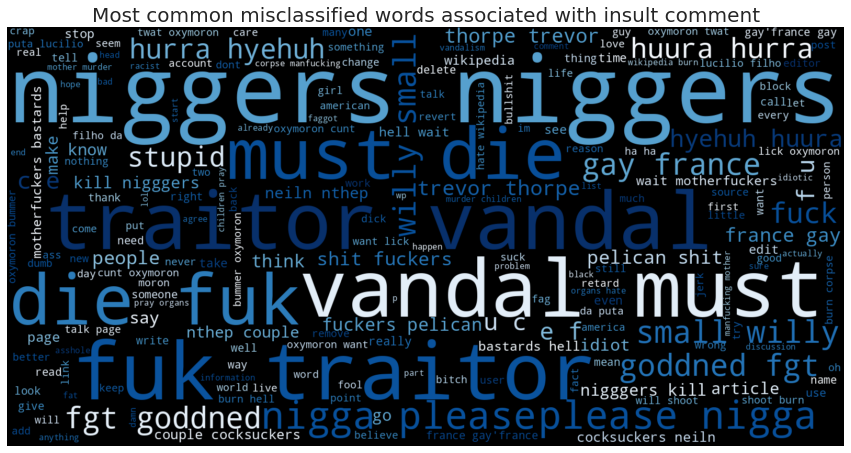

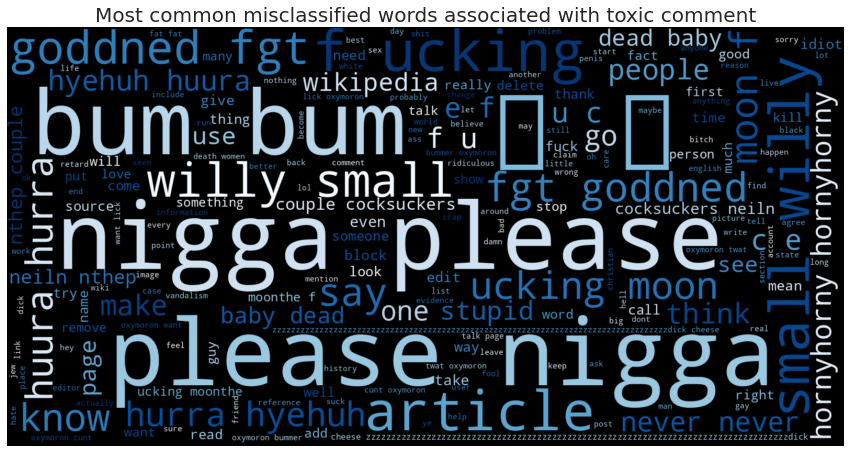

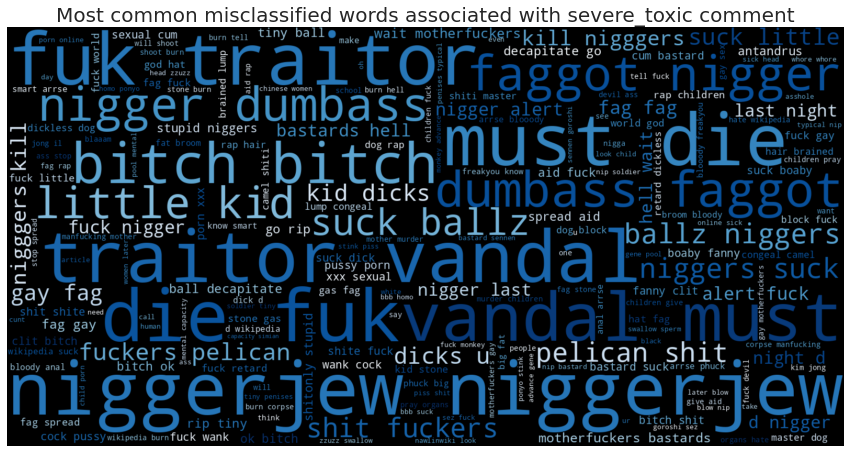

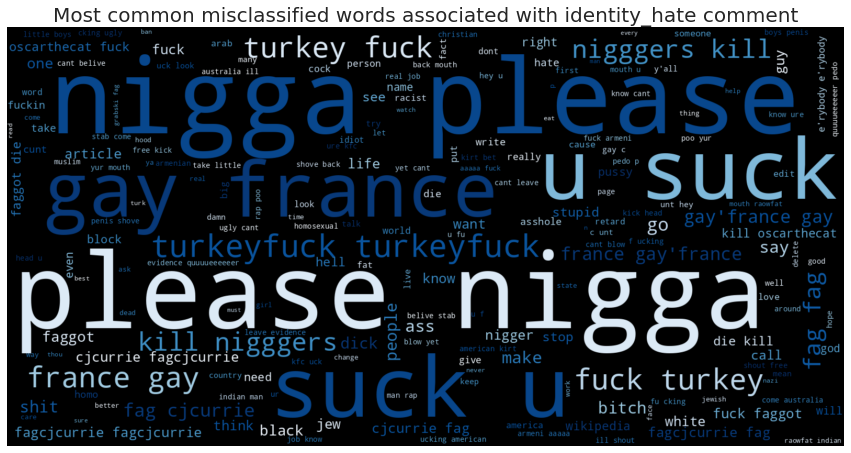

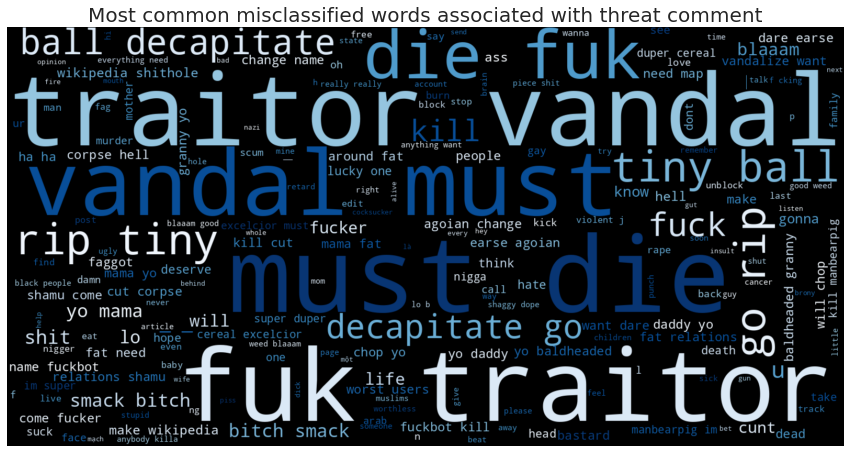

In [48]:
for label in labels:
    W_Cloud(label)

Let's see how to toxic comments are close to each other's in embeddings space

In [49]:
# Reduce vectors dimensions using TSNE
embeddings_2d = TSNE(n_components=2, learning_rate='auto',
                     init='random').fit_transform(train_trans_X[:10000])

<function matplotlib.pyplot.show(close=None, block=None)>

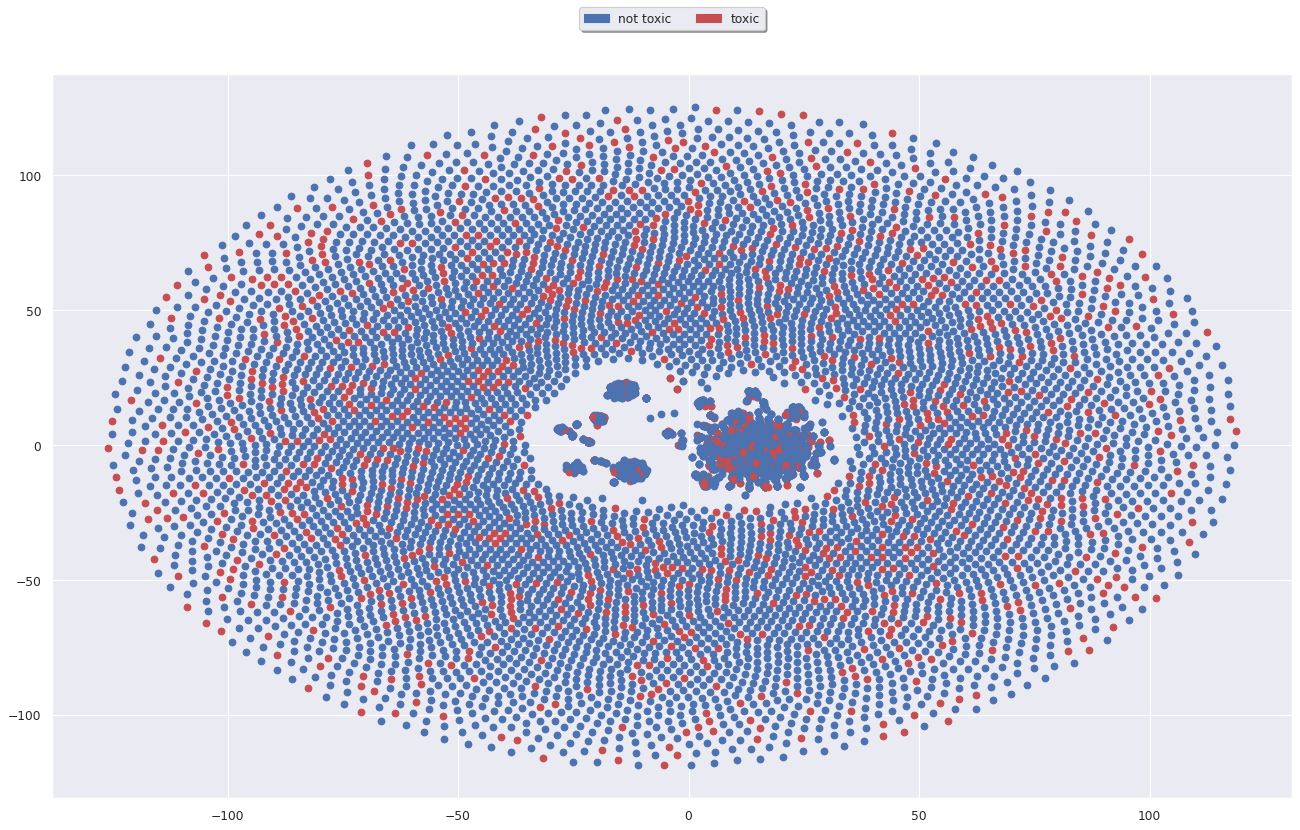

In [50]:
# Plot
figure(figsize=(20, 12), dpi=80)

i = 0
for x,y in embeddings_2d:
    safe = True
    for label in labels:
        if predicted_chains['toxic'][i] == 1:
            safe = False
    if safe:
        plt.plot(x,y,'o',color='b', label='safe')
    else:
        plt.plot(x,y,'o',color='r', label='toxic')
    i += 1
patches = []
safe_patch = mpatches.Patch(color='b', label='not toxic')
patches.append(safe_patch)
toxic_patch = mpatches.Patch(color='r', label='toxic')
patches.append(toxic_patch)

plt.legend(handles=patches,loc='upper center', bbox_to_anchor=(0.5, 1.1),
           ncol=10, fancybox=True, shadow=True)
plt.show